[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Denis-R-V/TSR/blob/main/simple_detector_v2.ipynb)

# Система распознавания дорожных знаков на датасете RTSD

## Детектор. Инференс и метрики

In [1]:
colab = False

if colab == True:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install fiftyone
if colab == True:
    dataset_path = '.'
    checkpoints_path = '../content/drive/MyDrive/TSR/checkpoints'
else:
    dataset_path = 'data'
    checkpoints_path = 'checkpoints'

import json
import os
#import numpy as np 
#import pandas as pd 
import random
import time

#import cv2
import torch
#import torch.utils.data
#from torch.utils.data import Dataset, DataLoader
import torchvision
#import torchvision.transforms as transforms
from torchvision.transforms import functional as func       # ?
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
#from torchvision.models.detection import FasterRCNN

from PIL import Image
import matplotlib.pyplot as plt
#import matplotlib.patches as patches
%matplotlib inline

#from pycocotools.coco import COCO
import fiftyone as fo

### Загрузка графиков потерь по эпохам

In [2]:
device_id = 0
if torch.cuda.is_available() == True:
    device = f'cuda:{device_id}'
#elif torch.backends.mps.is_available() == True:
#    device = 'mps'
else:
    device = 'cpu'

device

'cuda:0'

### Графики лоссов моделей mobilenet v3 320 и mobilenet v3 (размер батча 8)

In [3]:
def get_plot_models(last_epoch, list_models, width_plot=10):
    
    # количество моделей
    n_models = len(list_models) 

    # Строим графики для resnet50_b8 и resnet50_v2_b8
    fig, ax = plt.subplots(nrows=1,ncols=n_models, sharey=True) 
    #for i in range(n_models):
    #    locals()['ax'+str(i+1)] = ax.flatten()

    for i in range(2):
        # Загрузки лоссов из чекпойнта
        model_name = list_models[i]
        checkpoint = torch.load(os.path.join(checkpoints_path, f'chkpt_detector_{model_name}_{last_epoch}.pth'), map_location=device)
        train_losses = checkpoint['losses_train']
        val_losses = checkpoint['losses_val']
        # построение графиков
        ax[i].plot(train_losses, label='Train')
        ax[i].plot(val_losses, label='Val')
        ax[i].set_title(model_name)
        ax[i].set(xlabel='Epoch', ylabel='Loss')
        ax[i].legend()

    fig.set_size_inches(width_plot, 3)
    plt.subplots_adjust(hspace=0,wspace=0.1)
    plt.show()
    return None

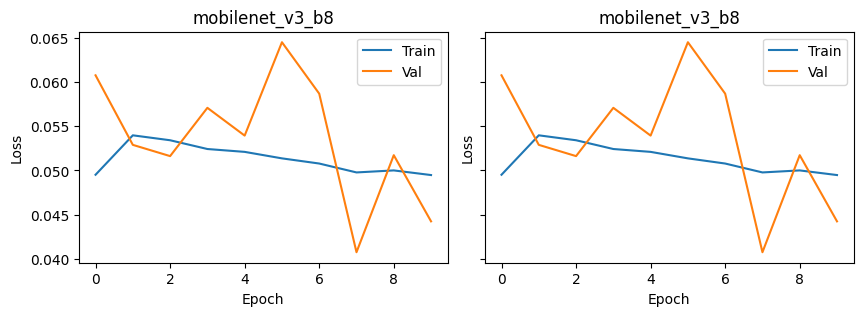

In [123]:
# Графики лоссов моделей mobilenet_v3_320_b8 и mobilenet_v3_b8 (размер батча 8)
#get_plot_models(last_epoch = 9, list_models = ['mobilenet_v3_320_b8', 'mobilenet_v3_b8'])
get_plot_models(last_epoch = 9, list_models = ['mobilenet_v3_b8', 'mobilenet_v3_b8'])

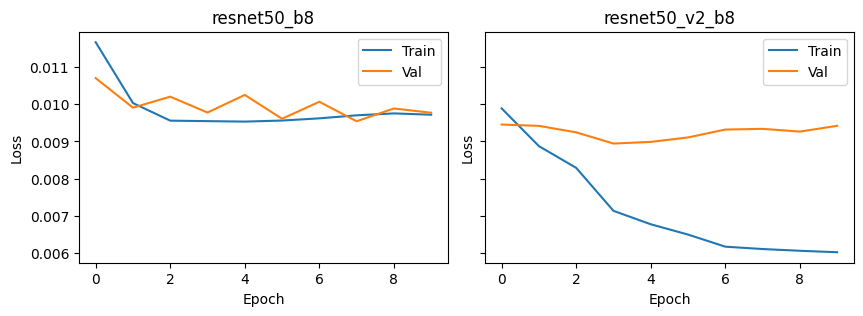

In [126]:
# Графики лоссов моделей resnet50 и resnet50_v2 (размер батча 8)
get_plot_models(last_epoch = 9, list_models = ['resnet50_b8', 'resnet50_v2_b8'])

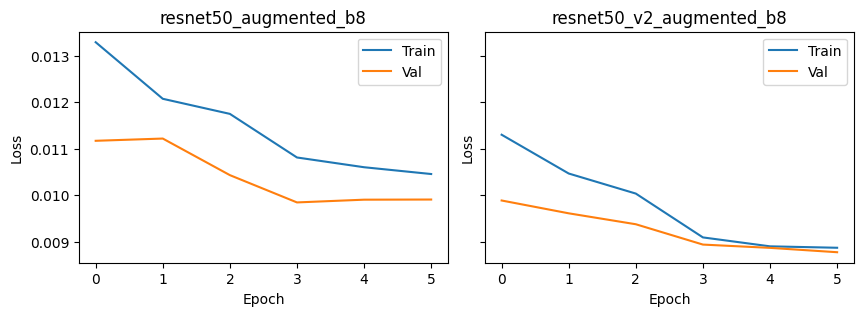

In [4]:
# Графики лоссов моделей resnet50 и resnet50_v2 с аугментацией (размер батча 8)
get_plot_models(last_epoch = 5, list_models = ['resnet50_augmented_b8', 'resnet50_v2_augmented_b8'])

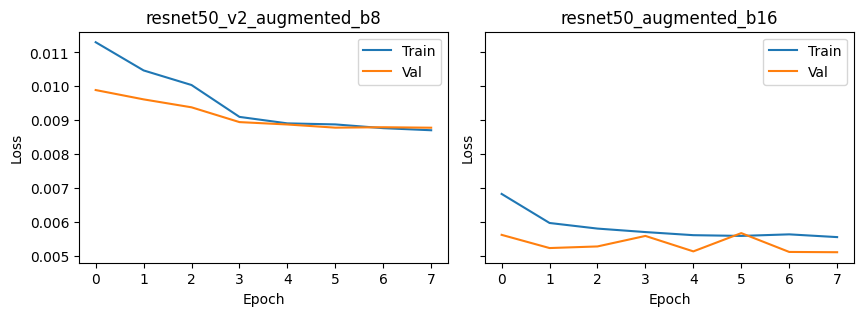

In [130]:
# Графики лоссов моделей resnet50 и resnet50_v2 с аугментацией (размер батча 16)
get_plot_models(last_epoch = 7, list_models = ['resnet50_v2_augmented_b8', 'resnet50_augmented_b16'])

### Общие параметры

In [106]:
device_id = 0
if torch.cuda.is_available() == True:
    device = f'cuda:{device_id}'
#elif torch.backends.mps.is_available() == True:
#    device = 'mps'
else:
    device = 'cpu'

#model_name = 'mobilenet_v3_320_b8'          # еще не обучена
#model_name = 'mobilenet_v3_b8'
#model_name = 'resnet50_b8'
#model_name = 'resnet50_v2_b8'
#model_name = 'resnet50_augmented_b8'
#model_name = 'resnet50_v2_augmented_b8'
model_name = 'resnet50_augmented_b16'
#model_name = 'resnet50_v2_augmented_b16'

### График потерь для выбранного графика

Для модели resnet50_augmented_b16 loss для 7 эпохи составляет 0.005101670296490193


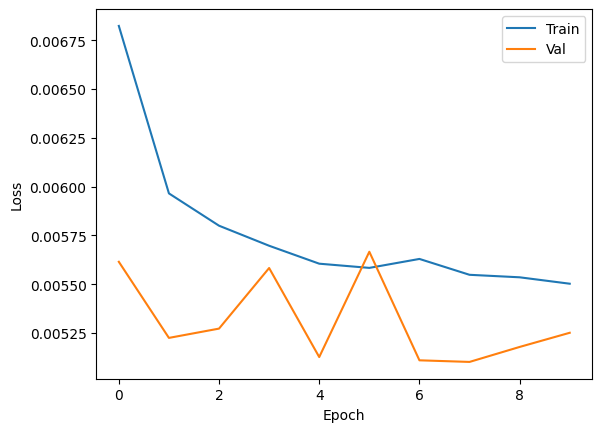

In [107]:
# последняя эпоха для загрузки параметров
last_epoch = 9   

# Загрузки лоссов из чекпойнта
checkpoint = torch.load(os.path.join(checkpoints_path, f'chkpt_detector_{model_name}_{last_epoch}.pth'), map_location=device)
train_losses = checkpoint['losses_train']
val_losses = checkpoint['losses_val']

# Эпоха с наименьшим loss на валидационной выборке
min_loss = min(val_losses)
for i in range(len(val_losses)):
    if val_losses[i] == min_loss:
        epoch_min_loss = i
        break
del checkpoint
print(f"Для модели {model_name} loss для {epoch_min_loss} эпохи составляет {min_loss}")

# Построение графика
fig, ax = plt.subplots()
ax.plot(train_losses, label='Train')
ax.plot(val_losses, label='Val')
ax.set(xlabel='Epoch', ylabel='Loss')
ax.legend()
plt.show()

### Загрузка модели и параметров

In [87]:
def load_model_detection(model_name, num_classes, epoch):
    # load model
    if (model_name == 'resnet50_b8') or (model_name == 'resnet50_augmented_b8') or (model_name == 'resnet50_augmented_b16'):
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None)
        print("Загружена модель resnet50")
    elif (model_name == 'resnet50_v2_b8') or (model_name == 'resnet50_v2_augmented_b8') or (model_name == 'resnet50_v2_augmented_b16'):
        model =torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights=None)
        print("Загружена модель resnet50_v2")
    elif model_name == 'mobilenet_v3_b8':
        model =torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(weights=None)
        print("Загружена модель mobilenet_v3")
    elif model_name == 'mobilenet_v3_320_b8':    
        model =torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(weights=None)
        print("Загружена модель mobilenet_v3_320")
    else:
        print("Неверно указано название модели")
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    # Загрузка весов модели
    checkpoint = torch.load(os.path.join(checkpoints_path, f'chkpt_detector_{model_name}_{epoch}.pth'), map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Для модели {model_name} загружены веса эпохи {epoch}")
    return model

In [108]:
epoch = 3      # выбираем эпоху для загрузки весов (если не указана - берем эпоху с наименьшем лоссом)

if epoch is None:
    epoch = epoch_min_loss
    
model = load_model_detection(model_name, num_classes=2, epoch=epoch).to(device)

Загружена модель resnet50
Для модели resnet50_augmented_b16 загружены веса эпохи 3


### Детекция знаков на одном изображении

In [7]:
def get_prediction_one_image(img_path, img_name, threshold):
    model.eval()
    img = Image.open(os.path.join(img_path, img_name))
    transforms=torchvision.transforms.ToTensor()
    img = transforms(img).to(device)
    
    prediction = model([img])
    pred_boxes = [[i[0], i[1], i[2], i[3]] for i in list(prediction[0]['boxes'].detach().cpu().numpy())]
    pred_labels = list(prediction[0].get('labels').cpu().numpy())
    pred_scores = list(prediction[0].get('scores').detach().cpu().numpy())
    pred_tr = [pred_scores.index(x) for x in pred_scores if x > threshold][-1]
    pred_labels = pred_labels[:pred_tr+1]
    pred_boxes = pred_boxes[:pred_tr+1]
    pred_scores = pred_scores[:pred_tr+1]
    
    #boxes = []
    #for i in range(num_objs):
    #    min = coco_annotation[i]['bbox'][0]
    #    ymin = coco_annotation[i]['bbox'][1]
    #    xmax = xmin + coco_annotation[i]['bbox'][2]
    #    ymax = ymin + coco_annotation[i]['bbox'][3]
    #    boxes.append([xmin, ymin, xmax, ymax])
    
    return pred_boxes, pred_labels, pred_scores


time_start = time.time()
img_name = 'rtsd-frames/autosave16_10_2012_08_58_25_5.jpg'
threshold = 0.1
prediction = get_prediction_one_image(dataset_path, img_name, threshold)
time_end = time.time()
prediction, time_end-time_start


(([[1142.6139, 9.806735, 1275.8627, 148.39044]], [1], [0.99602246]),
 3.3929250240325928)

In [9]:
time_inference = []
for i in range(1000):
    time_start = time.time()
    img_name = 'rtsd-frames/autosave16_10_2012_08_58_25_5.jpg'
    threshold = 0.1
    prediction = get_prediction_one_image(dataset_path, img_name, threshold)
    time_end = time.time()
    time_inference.append(time_end-time_start)
    prediction, time_end-time_start
min(time_inference), sum(time_inference)/len(time_inference), max(time_inference)

(0.08577108383178711, 0.09261430215835571, 0.11070442199707031)

In [20]:
def get_predict_anno(images_path, img_name, threshold):

    if img_name == None:
        with open(os.path.join(dataset_path, 'val_anno.json'), 'r') as read_file:
            val_anno = json.load(read_file)
        read_file.close()
        img_name = val_anno.get('images')[random.randint(0, len(val_anno.get('images')))].get('file_name')

    pred_boxes, pred_labels, pred_scores = get_prediction_one_image(images_path, img_name, threshold)
    anno = {}

    images = []
    image_item = {}
    image_item['id'] = 0
    img = Image.open(os.path.join(images_path, img_name))
    transforms=torchvision.transforms.ToTensor()
    img = transforms(img).to(device)
    image_item['width'] = img.shape[2]
    image_item['height'] = img.shape[1]
    image_item['file_name'] = img_name
    images.append(image_item)
    anno['images'] = images

    annotations = []
    for i in range(len(pred_boxes)):
        anno_item = {}
        anno_item['id'] = i
        anno_item['image_id'] = 0
        anno_item['category_id'] = int(pred_labels[i])
        anno_item['area'] = (float(pred_boxes[i][2]) - float(pred_boxes[i][0]))*(float(pred_boxes[i][3]) - float(pred_boxes[i][1]))     # Исправить, так как COCO формат
        anno_item['bbox'] = [float(pred_boxes[i][0]), float(pred_boxes[i][1]), float(pred_boxes[i][2]) - float(pred_boxes[i][0]), float(pred_boxes[i][3]) - float(pred_boxes[i][1])]
        anno_item['iscrowd'] = 0
        annotations.append(anno_item)
    anno['annotations'] = annotations
    
    anno['categories'] = [{'id': 1, 'name': 'sign'}]

    with open(os.path.join(dataset_path, 'predicted_anno.json'), 'w') as f:
        json.dump(anno, f)#ensure_ascii=False, indent=4)
    f.close()

    # загрузка изображения в fiftyone
    data_path = images_path      # можно не указывать, если в JSON путь совпадает

    # The path yo the COCO labels JSON file
    labels_file = "train_anno_bin_class.json"
    labels_path = os.path.join(dataset_path, 'predicted_anno.json')


    # Import the dataset
    dataset = fo.Dataset.from_dir(
        dataset_type=fo.types.COCODetectionDataset,
        data_path=data_path,
        labels_path=labels_path
    )
    # Визуализация набора данных
    session = fo.launch_app(dataset)

    return anno

In [ ]:
threshold = 0
#img_name = None
img_name = 'rtsd-frames/autosave13_04_2013_09_48_32_2.jpg'
#img_name = 'rtsd-frames/autosave16_10_2012_08_58_25_5.jpg'
#img_name = 'rtsd-frames/autosave01_02_2012_09_24_03.jpg'
#prediction_anno = get_predict_anno(dataset_path, , threshold)
prediction_anno = get_predict_anno(dataset_path, img_name, threshold)

### Детекция знаков на списке изображений

In [53]:
def get_prediction_list_images(images_path, img_list, threshold):
    model.eval()
    transforms=torchvision.transforms.ToTensor()
    images = []
    for image in img_list:
        img = Image.open(os.path.join(images_path, image)) 
        img = transforms(img).to(device)
        images.append(img)
            
    predictions = model(images)
    
    results = []
    for prediction in predictions:
        result = []
        pred_boxes = [[i[0], i[1], i[2], i[3]] for i in list(prediction['boxes'].detach().cpu().numpy())]
        pred_labels = list(prediction.get('labels').cpu().numpy())
        pred_scores = list(prediction.get('scores').detach().cpu().numpy())

        pred_tr = [pred_scores.index(x) for x in pred_scores if x > threshold][-1]
        pred_labels = pred_labels[:pred_tr+1]
        pred_boxes = pred_boxes[:pred_tr+1]
        pred_scores = pred_scores[:pred_tr+1]
        result.append(pred_boxes)
        result.append(pred_labels)
        result.append(pred_scores)
        results.append(result)
    #boxes = []
    #for i in range(num_objs):
    #    min = coco_annotation[i]['bbox'][0]
    #    ymin = coco_annotation[i]['bbox'][1]
    #    xmax = xmin + coco_annotation[i]['bbox'][2]
    #    ymax = ymin + coco_annotation[i]['bbox'][3]
    #    boxes.append([xmin, ymin, xmax, ymax])
    
    return results#pred_boxes, pred_labels, pred_scores

time_start = time.time()
img_list = ['rtsd-frames/autosave16_10_2012_08_58_25_5.jpg',
            'rtsd-frames/autosave01_02_2012_09_24_03.jpg']
threshold = 0.1
prediction = get_prediction_list_images(dataset_path, img_list, threshold)
time_end = time.time()
prediction, time_end-time_start

([[[[1145.4895, 11.639816, 1268.7242, 147.98634],
    [1170.4521, 142.16241, 1280.0, 243.36542]],
   [1, 1],
   [0.99661154, 0.16042183]],
  [[[1143.6453, 254.2227, 1211.5082, 319.71753],
    [394.17804, 678.96155, 410.93066, 696.3559]],
   [1, 1],
   [0.99057627, 0.15379326]]],
 0.3266324996948242)

In [ ]:
threshold = 0.5
#img_name = None
img_name = 'rtsd-frames/autosave13_04_2013_09_48_32_2.jpg'
#img_name = 'rtsd-frames/autosave16_10_2012_08_58_25_5.jpg'
#img_name = 'rtsd-frames/autosave01_02_2012_09_24_03.jpg'
#prediction_anno = get_predict_anno(dataset_path, , threshold)
prediction_anno = get_predict_anno(dataset_path, img_name, threshold)

### Детекция знаков на списке изображений

In [55]:
def get_prediction_list_images(images_path, img_list, threshold):
    model.eval()
    transforms=torchvision.transforms.ToTensor()
    images = []
    for image in img_list:
        img = Image.open(os.path.join(images_path, image)) 
        img = transforms(img).to(device)
        images.append(img)
            
    predictions = model(images)
    
    results = []
    for prediction in predictions:
        result = []
        pred_boxes = [[i[0], i[1], i[2], i[3]] for i in list(prediction['boxes'].detach().cpu().numpy())]
        pred_labels = list(prediction.get('labels').cpu().numpy())
        pred_scores = list(prediction.get('scores').detach().cpu().numpy())

        pred_tr = [pred_scores.index(x) for x in pred_scores if x > threshold][-1]
        pred_labels = pred_labels[:pred_tr+1]
        pred_boxes = pred_boxes[:pred_tr+1]
        pred_scores = pred_scores[:pred_tr+1]
        result.append(pred_boxes)
        result.append(pred_labels)
        result.append(pred_scores)
        results.append(result)
    #boxes = []
    #for i in range(num_objs):
    #    min = coco_annotation[i]['bbox'][0]
    #    ymin = coco_annotation[i]['bbox'][1]
    #    xmax = xmin + coco_annotation[i]['bbox'][2]
    #    ymax = ymin + coco_annotation[i]['bbox'][3]
    #    boxes.append([xmin, ymin, xmax, ymax])
    
    return results#pred_boxes, pred_labels, pred_scores

time_start = time.time()
img_list = ['rtsd-frames/autosave16_10_2012_08_58_25_5.jpg',
            'rtsd-frames/autosave01_02_2012_09_24_03.jpg']
threshold = 0.1
prediction = get_prediction_list_images(dataset_path, img_list, threshold)
time_end = time.time()
prediction, time_end-time_start


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds



([[[[1145.4895, 11.639816, 1268.7242, 147.98634],
    [1170.4521, 142.16241, 1280.0, 243.36542]],
   [1, 1],
   [0.99661154, 0.16042183]],
  [[[1143.6453, 254.2227, 1211.5082, 319.71753],
    [394.17804, 678.96155, 410.93066, 696.3559]],
   [1, 1],
   [0.99057627, 0.15379326]]],
 78.96233487129211)

 100% |███████████████████| 15/15 [135.0ms elapsed, 0s remaining, 112.0 samples/s]    



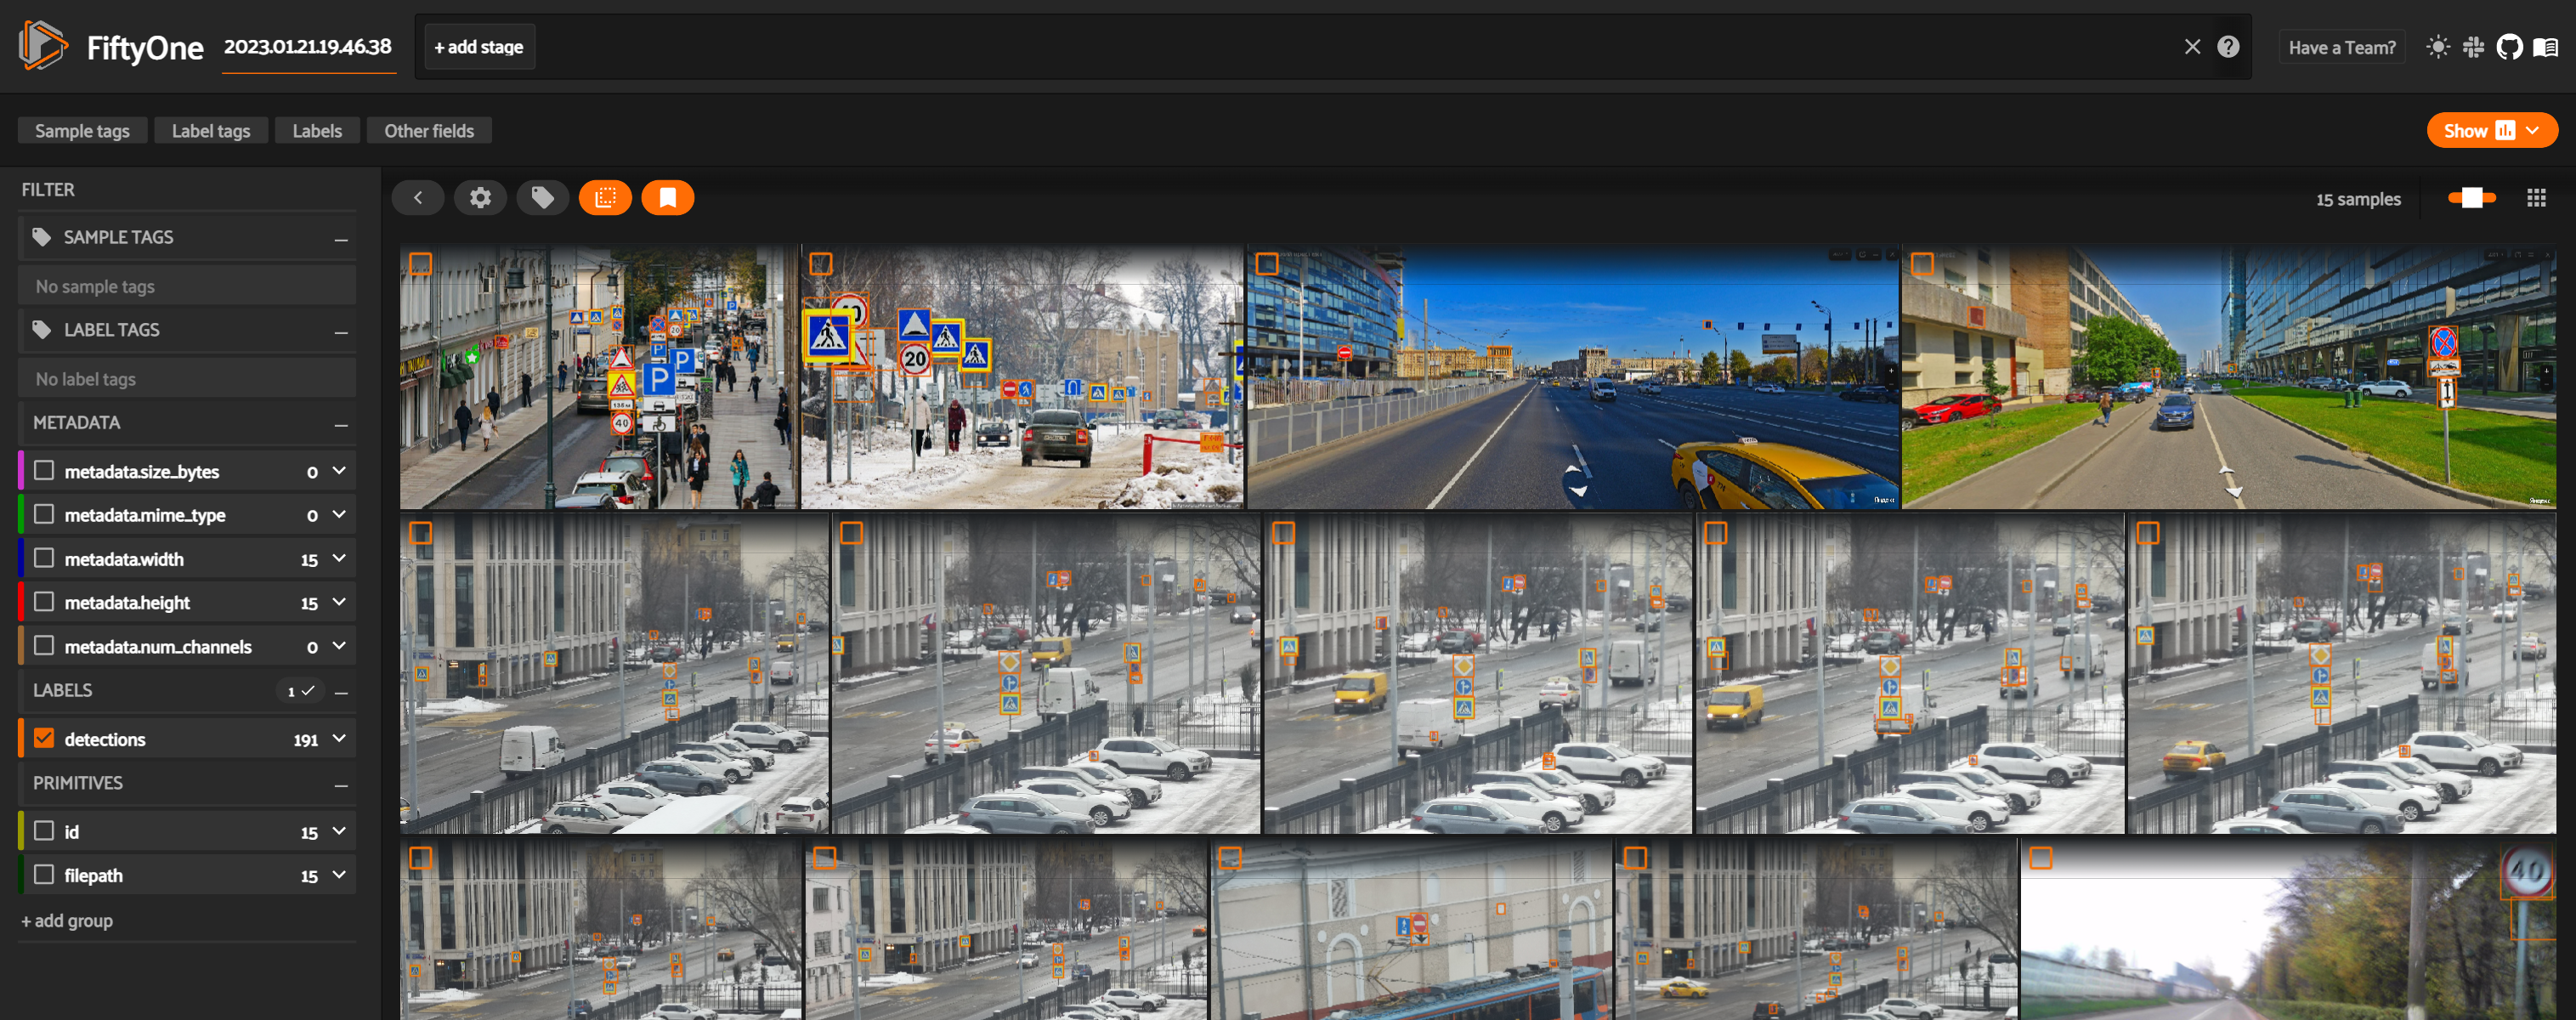

[([[516.2557, 322.12872, 585.0673, 383.90442],
   [525.5312, 420.27536, 581.42303, 475.4893],
   [520.39185, 253.43721, 581.0909, 316.4232],
   [524.17096, 154.93657, 554.45667, 189.43616],
   [520.59143, 386.57367, 584.1751, 413.5868],
   [666.2101, 195.8728, 703.2398, 232.77254],
   [422.2449, 167.66193, 455.07428, 200.42099],
   [528.98456, 189.76437, 551.81, 215.25414],
   [470.90164, 164.29944, 504.25198, 200.62267],
   [236.87375, 229.23552, 268.0208, 260.06488],
   [665.561, 161.4505, 704.5116, 201.56902],
   [759.70416, 138.31465, 776.4823, 156.67715],
   [621.1661, 180.1469, 661.0911, 220.09525],
   [827.21893, 235.34578, 850.9015, 265.15982],
   [711.5852, 161.02711, 744.0286, 196.11473],
   [621.9293, 220.8881, 661.7606, 251.0836],
   [827.8481, 235.83293, 846.60406, 254.48245]],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [0.9954249,
   0.99391633,
   0.9870718,
   0.8981047,
   0.8333414,
   0.7646591,
   0.74858034,
   0.74286455,
   0.74235904,
   0.7153708,

In [56]:
def get_predict_anno_list_images(images_path, img_list, threshold):

    if img_list == None:
        with open(os.path.join(dataset_path, 'val_anno.json'), 'r') as read_file:
            val_anno = json.load(read_file)
        read_file.close()
        img_list = [val_anno.get('images')[random.randint(0, len(val_anno.get('images')))].get('file_name')]

    predict = []
    for image in img_list:
        one_predict = get_prediction_one_image(dataset_path, image, threshold)
        predict.append(one_predict)
    anno = {}
    anno_item_id = 0

    transforms=torchvision.transforms.ToTensor()
    images = []
    annotations = []
    for i in range(len(predict)):
        img = Image.open(os.path.join(images_path, img_list[i]))
        img = transforms(img).to(device)
        
        image_item = {}
        image_item['id'] = i
        image_item['width'] = img.shape[2]
        image_item['height'] = img.shape[1]
        image_item['file_name'] = img_list[i]
        images.append(image_item)

        prediction = predict[i]
        for j in range(len(prediction[0])):
            
            anno_item = {}
            anno_item['id'] = anno_item_id
            anno_item_id += 1
            anno_item['image_id'] = i
            anno_item['category_id'] = int(prediction[1][j])
            anno_item['area'] = (float(prediction[0][j][2]) - float(prediction[0][j][0]))*(float(prediction[0][j][3]) - float(prediction[0][j][1]))
            anno_item['bbox'] = [float(prediction[0][j][0]), float(prediction[0][j][1]), float(prediction[0][j][2]) - float(prediction[0][j][0]), float(prediction[0][j][3]) - float(prediction[0][j][1])]
            anno_item['iscrowd'] = 0
            annotations.append(anno_item)
    
    anno['images'] = images
    anno['annotations'] = annotations
    anno['categories'] = [{'id': 1, 'name': 'sign'}]


    result = predict

    with open(os.path.join(dataset_path, 'predicted_anno.json'), 'w') as f:
        json.dump(anno, f)#ensure_ascii=False, indent=4)
    f.close()

    # загрузка изображения в fiftyone
    data_path = images_path      # можно не указывать, если в JSON путь совпадает

    # The path yo the COCO labels JSON file
    labels_path = os.path.join(dataset_path, 'predicted_anno.json')


    # Import the dataset
    dataset = fo.Dataset.from_dir(
        dataset_type=fo.types.COCODetectionDataset,
        data_path=data_path,
        labels_path=labels_path
    )
    # Визуализация набора данных
    session = fo.launch_app(dataset)

    return result#annotations


threshold = 0.1
img_list = ['image_for_predict/image1.jpg',                     # картинка из интернета
            'image_for_predict/image2.jpg',                     # картинка из интернета
            'image_for_predict/screen1.jpg',                    # скрин я яндекс карт
            'image_for_predict/screen2.jpg',                    # скрин я яндекс карт
            'image_for_predict/p20_1.jpg',                      # снимок из окна кабинета
            'image_for_predict/p20_2.jpg',                      # снимок из окна кабинета
            'image_for_predict/p20_3.jpg',                      # снимок из окна кабинета
            'image_for_predict/p20_4.jpg',                      # снимок из окна кабинета
            'image_for_predict/p20_5.jpg',                      # снимок из окна кабинета
            'image_for_predict/p20_6.jpg',                      # снимок из окна кабинета
            'image_for_predict/p20_7.jpg',                      # снимок из окна кабинета
            'image_for_predict/p20_8.jpg',                      # снимок из окна кабинета
            'image_for_predict/p20_9.jpg',                      # снимок из окна кабинета
            'rtsd-frames/autosave16_10_2012_08_58_25_5.jpg',    # тестовая выборка
            'rtsd-frames/autosave01_02_2012_09_24_03.jpg'       # тестовая выборка 
            ]

#prediction_anno = get_predict_anno_list_images(dataset_path, None, threshold)
prediction_anno = get_predict_anno_list_images(dataset_path, img_list, threshold)
prediction_anno

### Рассчет метрик модели на валидационной выборке

Загрузка валидационного датасета

In [109]:
#Load val dataset COCO

# The directiry containing the source images
data_path = dataset_path      # можно не указывать, если в JSON путь совпадает

# The path yo the COCO labels JSON file
val_anno_file = "val_anno_bin_class.json"
val_anno_path = os.path.join(dataset_path, val_anno_file)

# Import the dataset
val_dataset = fo.Dataset.from_dir(
    dataset_type=fo.types.COCODetectionDataset,
    data_path=data_path,
    labels_path=val_anno_path
)

 100% |███████████████| 5000/5000 [8.5s elapsed, 0s remaining, 598.8 samples/s]      


In [30]:
#predictions_view = val_dataset.take(50, seed=42)

In [110]:
# Add and evaluating Faster-RCNN detections
# Faster-RCNN detections can be calculated and added to every sample of the dataset in a new field


'''# Load the pretrained PyTorch model
def load_model_detection(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model =torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

num_classes = 2
model = load_model_detection(num_classes)

# Run the model on GPU if it is available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Загрузка весов модели
checkpoint = torch.load('checkpoints/chkpt_detector_resnet50_augmented_2.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()'''

#classes = predictions_view.default_classes
classes = val_dataset.default_classes
# Add predictions
#for sample in predictions_view:
model.eval()
for i, sample in enumerate(val_dataset):
    image = Image.open(sample.filepath)
    image = func.to_tensor(image).to(device)
    c,h,w = image.shape
    preds = model([image])[0]
    labels = preds['labels'].cpu().detach().numpy()
    scores = preds['scores'].cpu().detach().numpy()
    boxes = preds['boxes'].cpu().detach().numpy()
    detections = []
    for label, score, box in zip (labels, scores, boxes):
        # Compute relative bounding box coordinates
        x1, y1, x2, y2 = box
        rel_box = [x1/w, y1/h, (x2-x1)/w, (y2-y1)/h]
        detections.append(fo.Detection(label=classes[label],
                                        bounding_box=rel_box,
                                        confidence=score
                                        )
                            )
    sample['faster_rcnn'] = fo.Detections(detections=detections)
    sample.save()
    if i % 100 == 0:
            print(f"\tОбработано {i} из {val_dataset.__len__()} сэмплов.")

	Обработано 0 из 5000 сэмплов.
	Обработано 100 из 5000 сэмплов.
	Обработано 200 из 5000 сэмплов.
	Обработано 300 из 5000 сэмплов.
	Обработано 400 из 5000 сэмплов.
	Обработано 500 из 5000 сэмплов.
	Обработано 600 из 5000 сэмплов.
	Обработано 700 из 5000 сэмплов.
	Обработано 800 из 5000 сэмплов.
	Обработано 900 из 5000 сэмплов.
	Обработано 1000 из 5000 сэмплов.
	Обработано 1100 из 5000 сэмплов.
	Обработано 1200 из 5000 сэмплов.
	Обработано 1300 из 5000 сэмплов.
	Обработано 1400 из 5000 сэмплов.
	Обработано 1500 из 5000 сэмплов.
	Обработано 1600 из 5000 сэмплов.
	Обработано 1700 из 5000 сэмплов.
	Обработано 1800 из 5000 сэмплов.
	Обработано 1900 из 5000 сэмплов.
	Обработано 2000 из 5000 сэмплов.
	Обработано 2100 из 5000 сэмплов.
	Обработано 2200 из 5000 сэмплов.
	Обработано 2300 из 5000 сэмплов.
	Обработано 2400 из 5000 сэмплов.
	Обработано 2500 из 5000 сэмплов.
	Обработано 2600 из 5000 сэмплов.
	Обработано 2700 из 5000 сэмплов.
	Обработано 2800 из 5000 сэмплов.
	Обработано 2900 из 5000 с

In [111]:
#session = fo.launch_app(predictions_view)
session = fo.launch_app(val_dataset)

In [112]:
# Evaluate the predictions in the `faster_rcnn` field of our `high_conf_view`
# with respect to the objects in the `ground_truth` field
def get_metrics():
    results = val_dataset.evaluate_detections(
        "faster_rcnn",
        gt_field="detections",
        eval_key="eval",
        compute_mAP=True,
    )
    model_metrics = results.metrics()
    model_metrics['mAP'] = results.mAP()
    return model_metrics


In [66]:
detector_mobilenet_v3_b8_metrics = get_metrics()
detector_mobilenet_v3_b8_metrics

Evaluating detections...
 100% |███████████████| 5000/5000 [29.1s elapsed, 0s remaining, 200.1 samples/s]      
Performing IoU sweep...
 100% |███████████████| 5000/5000 [28.0s elapsed, 0s remaining, 207.8 samples/s]      


{'accuracy': 0.3183152151448766,
 'precision': 0.33441896821261075,
 'recall': 0.8685991427926911,
 'fscore': 0.4829121464852323,
 'support': 8866,
 'mAP': 0.4491762945777367}

In [76]:
detector_resnet50_b8_metrics = get_metrics()
detector_resnet50_b8_metrics

Evaluating detections...
 100% |███████████████| 5000/5000 [25.0s elapsed, 0s remaining, 280.1 samples/s]      
Performing IoU sweep...
 100% |███████████████| 5000/5000 [24.8s elapsed, 0s remaining, 262.7 samples/s]      


{'accuracy': 0.3943016921371065,
 'precision': 0.4078081372157958,
 'recall': 0.9225129709000677,
 'fscore': 0.565590208146048,
 'support': 8866,
 'mAP': 0.5697256951589675}

In [83]:
detector_resnet50_v2_b8_metrics = get_metrics()
detector_resnet50_v2_b8_metrics

Evaluating detections...
 100% |███████████████| 5000/5000 [18.4s elapsed, 0s remaining, 328.5 samples/s]      
Performing IoU sweep...
 100% |███████████████| 5000/5000 [18.4s elapsed, 0s remaining, 307.1 samples/s]      


{'accuracy': 0.7259713701431493,
 'precision': 0.8049886621315193,
 'recall': 0.8808933002481389,
 'fscore': 0.8412322274881515,
 'support': 8866,
 'mAP': 0.6102628978042013}

In [93]:
detector_resnet50_augmented_b8_metrics = get_metrics()
detector_resnet50_augmented_b8_metrics

Evaluating detections...
 100% |███████████████| 5000/5000 [25.6s elapsed, 0s remaining, 243.0 samples/s]      
Performing IoU sweep...
 100% |███████████████| 5000/5000 [27.2s elapsed, 0s remaining, 235.0 samples/s]      


{'accuracy': 0.5184007536948714,
 'precision': 0.5203002186631995,
 'recall': 0.993006993006993,
 'fscore': 0.682824679101873,
 'support': 8866,
 'mAP': 0.6816548952821027}

In [105]:
detector_resnet50_v2_augmented_b8_5_metrics = get_metrics()
detector_resnet50_v2_augmented_b8_5_metrics

Evaluating detections...
 100% |███████████████| 5000/5000 [19.6s elapsed, 0s remaining, 313.4 samples/s]      
Performing IoU sweep...
 100% |███████████████| 5000/5000 [20.5s elapsed, 0s remaining, 296.0 samples/s]      


{'accuracy': 0.6698579135324063,
 'precision': 0.6724124780718481,
 'recall': 0.994360478231446,
 'fscore': 0.8022933066387588,
 'support': 8866,
 'mAP': 0.6791738960931477}

In [100]:
detector_resnet50_v2_augmented_b8_7_metrics = get_metrics()
detector_resnet50_v2_augmented_b8_7_metrics

Evaluating detections...
 100% |███████████████| 5000/5000 [19.1s elapsed, 0s remaining, 318.0 samples/s]      
Performing IoU sweep...
 100% |███████████████| 5000/5000 [19.7s elapsed, 0s remaining, 290.5 samples/s]      


{'accuracy': 0.6938421509106678,
 'precision': 0.6974716652136007,
 'recall': 0.9925558312655087,
 'fscore': 0.819252432155658,
 'support': 8866,
 'mAP': 0.6745305457427215}

In [113]:
detector_resnet50_augmented_b16_3_metrics = get_metrics()
detector_resnet50_augmented_b16_3_metrics

Evaluating detections...
 100% |███████████████| 5000/5000 [20.8s elapsed, 0s remaining, 272.0 samples/s]      
Performing IoU sweep...
 100% |███████████████| 5000/5000 [21.5s elapsed, 0s remaining, 270.7 samples/s]      


{'accuracy': 0.5895387094608205,
 'precision': 0.5929627878706017,
 'recall': 0.990300022558087,
 'fscore': 0.7417733282642672,
 'support': 8866,
 'mAP': 0.6578381017991327}


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds

Could not connect session, trying again in 10 seconds



Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 s

In [47]:
detector_resnet50_augmented_b16_metrics = get_metrics()
detector_resnet50_augmented_b16_metrics

Evaluating detections...
 100% |███████████████| 5000/5000 [22.5s elapsed, 0s remaining, 287.6 samples/s]      
Performing IoU sweep...
 100% |███████████████| 5000/5000 [23.8s elapsed, 0s remaining, 265.7 samples/s]      


{'accuracy': 0.5294506949040371,
 'precision': 0.53156146179402,
 'recall': 0.9925558312655087,
 'fscore': 0.6923409779316315,
 'support': 8866,
 'mAP': 0.6676151070447385}